# Upper Confidence Bound BO


In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import torch


import matplotlib.pyplot as plt
from xopt import Xopt

The `Xopt` object can be instantiated from a JSON or YAML file, or a dict, with the proper structure.

Here we will make one

In [2]:
# Make a proper input file.
YAML = """
generator:
  name: upper_confidence_bound
  beta: 0.1

evaluator:
  function: xopt.resources.test_functions.sinusoid_1d.evaluate_sinusoid

vocs:
  variables:
    x1: [0, 6.28]
  objectives:
    y1: 'MINIMIZE'
"""

In [3]:
X = Xopt.from_yaml(YAML)
X


            Xopt
________________________________
Version: 0+untagged.1.gb759905
Data size: 0
Config as YAML:
dump_file: null
evaluator:
  function: xopt.resources.test_functions.sinusoid_1d.evaluate_sinusoid
  function_kwargs: {}
  max_workers: 1
  vectorized: false
generator:
  beta: 0.1
  computation_time: null
  fixed_features: null
  gp_constructor:
    covar_modules: {}
    mean_modules: {}
    name: standard
    trainable_mean_keys: []
    use_low_noise_prior: true
  max_travel_distances: null
  model: null
  n_candidates: 1
  n_monte_carlo_samples: 128
  name: upper_confidence_bound
  numerical_optimizer:
    max_iter: 2000
    n_restarts: 20
    name: LBFGS
  turbo_controller: null
  use_cuda: false
max_evaluations: null
serialize_inline: false
serialize_torch: false
strict: true
vocs:
  constants: {}
  constraints: {}
  objectives:
    y1: MINIMIZE
  observables: []
  variables:
    x1:
    - 0.0
    - 6.28


## Run Optimization

In [4]:
X.random_evaluate(3)
for i in range(5):
    print(i)
    X.step()

0
1
2
3
4


## View output data

In [5]:
X.data

,x1,y1,c1,xopt_runtime,xopt_error
0,2.544638,0.562126,-4.739663,0.000025,False
1,0.394297,0.384159,-5.286083,0.000005,False
2,2.761883,0.370651,-5.328499,0.000005,False
4,3.166417,-0.024822,-9.921120,0.000015,False
5,4.179228,-0.861205,-18.942694,0.000013,False
6,5.848119,-0.421470,-13.810685,0.000013,False
7,4.616407,-0.995397,-18.671315,0.000014,False
8,4.693632,-0.999824,-18.506848,0.000015,False


## Visualize model used by upper confidence bound
Models are kept in a list, in this case that list has one element, the model
created for the objective `y1`.


Text(0, 0.5, 'y1')

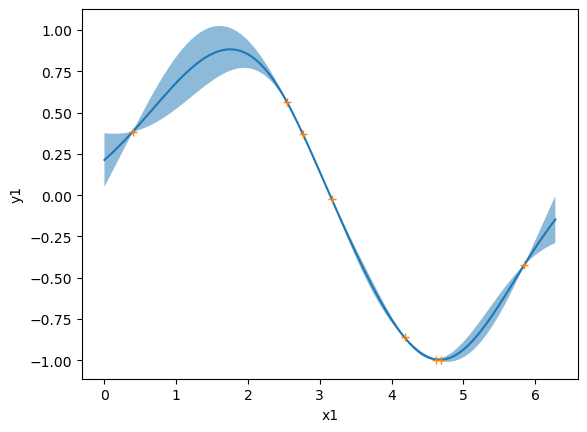

In [6]:
model = X.generator.model
bounds = X.vocs.bounds

test_x = torch.linspace(*bounds.flatten(), 100).double()

train_x = torch.tensor(X.data["x1"].to_numpy())
train_y = torch.tensor(X.data["y1"].to_numpy())

fig, ax = plt.subplots()
with torch.no_grad():
    post = model.models[0].posterior(test_x.reshape(-1,1,1))
    mean = post.mean.flatten()
    std = post.variance.sqrt().flatten()

    lower = mean - std
    upper = mean + std

ax.plot(test_x, mean)
ax.fill_between(test_x, lower, upper, alpha=0.5)
ax.plot(
    train_x.flatten(),
    train_y.flatten(),
    "+"
)
ax.set_xlabel("x1")
ax.set_ylabel("y1")


In [7]:
# Cleanup
!rm dump.yaml

rm: cannot remove 'dump.yaml': No such file or directory
